In [760]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import matplotlib.pyplot as plt


In [762]:
df = pd.read_csv("../../data/csv_files/df_ph1.csv")

In [764]:
df['dt'] = pd.to_datetime(df['dt'])

In [766]:
df.shape

(7748, 10)

In [768]:
stations_name = list(df.columns)
stations_name.remove('dt')

In [770]:
start_array = []
end_array = []
index = 3
start_na = True
print(stations_name[index])

for _, row in df.iterrows():
    if pd.isna(row[stations_name[index]]) and start_na:
        start_na = False
        start_array.append(row['dt'])
    elif not pd.isna(row[stations_name[index]]) and not start_na:
        start_na = True
        end_array.append(row['dt'])

FSB_126


In [772]:
time_duration = {}
for start, end in zip(start_array, end_array):
    time_duration[(start, end)] = pd.to_datetime(end) - pd.to_datetime(start)

In [774]:
for key, value in time_duration.items():
    if value > pd.Timedelta(days= 1):
        print(f"{key}: {value}")

(Timestamp('2023-07-28 08:00:00'), Timestamp('2023-07-31 13:00:00')): 3 days 05:00:00
(Timestamp('2023-07-31 14:00:00'), Timestamp('2023-08-03 22:00:00')): 3 days 08:00:00
(Timestamp('2023-08-04 07:00:00'), Timestamp('2023-08-08 04:00:00')): 3 days 21:00:00
(Timestamp('2023-08-09 11:00:00'), Timestamp('2023-08-13 16:00:00')): 4 days 05:00:00
(Timestamp('2023-08-13 20:00:00'), Timestamp('2023-08-19 05:00:00')): 5 days 09:00:00
(Timestamp('2023-08-19 09:00:00'), Timestamp('2023-08-21 19:00:00')): 2 days 10:00:00
(Timestamp('2023-08-23 20:00:00'), Timestamp('2023-08-28 16:00:00')): 4 days 20:00:00
(Timestamp('2023-08-28 17:00:00'), Timestamp('2023-08-31 07:00:00')): 2 days 14:00:00
(Timestamp('2023-08-31 22:00:00'), Timestamp('2023-10-18 14:45:00')): 47 days 16:45:00
(Timestamp('2024-01-01 01:00:00'), Timestamp('2024-01-24 14:06:00')): 23 days 13:06:00


In [776]:
first_range = ["2023-10-18 16:00:00", "2024-01-01 01:00:00"]
second_range = ["2024-01-24 14:06:00", "2024-06-13 01:00:00"]
time_ranges = [first_range, second_range]


In [778]:
conditions = [((df['dt'] >= start) & (df['dt'] < end)) for start, end in time_ranges]
combined_condition = conditions[0]
for condition in conditions[1:]:
    combined_condition |= condition

new_df = df[combined_condition]
new_df.shape

(5188, 10)

In [780]:
new_df.isna().sum()

dt             0
FEX_004       32
FSB_095DR     32
FSB_078       31
FSB_126      149
FSB_130D      32
FPZ_06A       35
FSB_079       30
FPZ_04A       33
FSB_097D     197
dtype: int64

In [782]:
df_interpolate = new_df.copy()
for col in stations_name:
    df_interpolate[col] = df_interpolate[col].interpolate()

In [784]:
df_interpolate.isna().sum()

dt           0
FEX_004      0
FSB_095DR    0
FSB_078      0
FSB_126      0
FSB_130D     0
FPZ_06A      0
FSB_079      0
FPZ_04A      1
FSB_097D     0
dtype: int64

In [786]:
df_interpolate.head()

,dt,FEX_004,FSB_095DR,FSB_078,FSB_126,FSB_130D,FPZ_06A,FSB_079,FPZ_04A,FSB_097D
1990,2023-10-18 16:00:00,4.083423,4.274505,4.192072,4.252175,4.238313,5.237623,8.214306,NaN,3.859401
1991,2023-10-18 16:08:00,4.082872,4.273696,4.187698,4.253654,4.238655,5.236429,8.213204,6.715425,3.859439
1992,2023-10-18 17:00:00,4.082322,4.272888,4.183324,4.255134,4.238997,5.235236,8.212103,6.707715,3.859476
1993,2023-10-18 18:00:00,4.083188,4.274658,4.187932,4.255432,4.238900,5.233563,8.212461,6.708187,3.859747
1994,2023-10-18 19:00:00,4.082988,4.274011,4.184526,4.254230,4.239076,5.233158,8.213062,6.707709,3.860002


In [788]:
df_interpolate = df_interpolate.fillna(6.723135)

In [790]:
df_interpolate.isna().sum().sum()

0

In [792]:
df_interpolate.shape

(5188, 10)

In [794]:
df_interpolate = df_interpolate.drop(columns = ["dt"])

In [796]:
df_interpolate[:10]

,FEX_004,FSB_095DR,FSB_078,FSB_126,FSB_130D,FPZ_06A,FSB_079,FPZ_04A,FSB_097D
1990,4.083423,4.274505,4.192072,4.252175,4.238313,5.237623,8.214306,6.723135,3.859401
1991,4.082872,4.273696,4.187698,4.253654,4.238655,5.236429,8.213204,6.715425,3.859439
1992,4.082322,4.272888,4.183324,4.255134,4.238997,5.235236,8.212103,6.707715,3.859476
1993,4.083188,4.274658,4.187932,4.255432,4.238900,5.233563,8.212461,6.708187,3.859747
1994,4.082988,4.274011,4.184526,4.254230,4.239076,5.233158,8.213062,6.707709,3.860002
1995,4.084110,4.273806,4.181676,4.257802,4.238262,5.233819,8.213025,6.706541,3.859652
1996,4.082468,4.273282,4.187973,4.252108,4.239463,5.234789,8.212464,6.706626,3.859819
1997,4.082752,4.272999,4.189883,4.252666,4.239695,5.235575,8.213947,6.705933,3.859644
1998,4.083474,4.273082,4.185086,4.253019,4.239472,5.237950,8.215273,6.705845,3.859744
1999,4.082767,4.273599,4.187633,4.252279,4.238428,5.238791,8.215713,6.705758,3.859739


In [798]:
def create_overlapping_sequences(df, rows_per_group, overlap):
    sequences = []
    for start in range(0, len(df) - rows_per_group + 1, rows_per_group - overlap):
        seq = df.iloc[start:start + rows_per_group].values.flatten()
        sequences.append(seq)
    return pd.DataFrame(sequences)

In [800]:
reshaped_df = create_overlapping_sequences(df_interpolate, 10, 3)
reshaped_df.shape


(740, 90)

In [802]:
input_array = reshaped_df.values.flatten()
reshaped_input_array = input_array.reshape(-1,9)
reshaped_input_df = pd.DataFrame(reshaped_input_array)

In [804]:
scaler = StandardScaler()
scaled_df = scaler.fit_transform(reshaped_df)

In [806]:
tensor_data = torch.tensor(scaled_df, dtype=torch.float32)

dataset = TensorDataset(tensor_data, tensor_data)
dataloader = DataLoader(dataset, batch_size = 64, shuffle = True)

In [808]:
class Autoencoder(nn.Module):
    def __init__(self, input_dim):
        super(Autoencoder, self).__init__()
        #encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 60),  
            nn.ReLU(),
            nn.Linear(60, 45),        
            nn.ReLU(),
            nn.Linear(45, 30),        
            nn.ReLU(),
        )
        
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(30, 45),         
            nn.ReLU(),
            nn.Linear(45, 60),        
            nn.ReLU(),
            nn.Linear(60, input_dim), 
            nn.Sigmoid()               
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [810]:
input_dim = scaled_df.shape[1]
model = Autoencoder(input_dim)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr = 0.001)

In [812]:
num_epochs = 100
losses = []
for epoch in range(num_epochs):
    for data in dataloader:
        inputs, _ = data
        
        
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, inputs)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    #appending the error to the losses array
    losses.append(loss.item())

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

Epoch [1/100], Loss: 1.2007
Epoch [2/100], Loss: 1.1601
Epoch [3/100], Loss: 0.9601
Epoch [4/100], Loss: 0.6880
Epoch [5/100], Loss: 0.7746
Epoch [6/100], Loss: 0.7283
Epoch [7/100], Loss: 0.5988
Epoch [8/100], Loss: 0.6848
Epoch [9/100], Loss: 0.5646
Epoch [10/100], Loss: 0.5412
Epoch [11/100], Loss: 0.6600
Epoch [12/100], Loss: 0.8863
Epoch [13/100], Loss: 0.7920
Epoch [14/100], Loss: 0.7209
Epoch [15/100], Loss: 0.7471
Epoch [16/100], Loss: 0.4406
Epoch [17/100], Loss: 0.3533
Epoch [18/100], Loss: 0.7806
Epoch [19/100], Loss: 0.6151
Epoch [20/100], Loss: 0.9395
Epoch [21/100], Loss: 0.6572
Epoch [22/100], Loss: 0.7260
Epoch [23/100], Loss: 0.6757
Epoch [24/100], Loss: 0.5396
Epoch [25/100], Loss: 0.3814
Epoch [26/100], Loss: 0.4102
Epoch [27/100], Loss: 0.5666
Epoch [28/100], Loss: 0.6445
Epoch [29/100], Loss: 0.5265
Epoch [30/100], Loss: 0.4899
Epoch [31/100], Loss: 0.5090
Epoch [32/100], Loss: 0.3096
Epoch [33/100], Loss: 0.7235
Epoch [34/100], Loss: 0.5627
Epoch [35/100], Loss: 0

In [813]:
model.eval()
with torch.no_grad():
    reconstructed_data = model(tensor_data)
    reconstruction_error = torch.mean((tensor_data - reconstructed_data) ** 2, axis=1).numpy()
print(len(reconstruction_error))

740


In [816]:
reconstructed_np = reconstructed_data.numpy()

In [818]:
predicted_df = pd.DataFrame(reconstructed_np)
predicted_df.head()

,0,1,2,3,4,5,6,7,8,9,...,80,81,82,83,84,85,86,87,88,89
0,0.0,3.419740e-38,1.220978e-18,1.787380e-12,5.249539e-26,0.000286,1.0,4.355732e-07,1.585778e-37,1.896120e-35,...,0.0,3.531286e-36,0.0,4.034236e-16,9.450013e-14,2.991429e-33,0.000238,1.0,2.322333e-07,0.0
1,0.0,2.304169e-38,1.017615e-18,1.281666e-12,4.408144e-26,0.000428,1.0,4.254900e-07,1.180124e-37,1.276068e-35,...,0.0,2.661450e-36,0.0,3.467449e-16,6.357654e-14,2.175956e-33,0.000371,1.0,2.374005e-07,0.0
2,0.0,2.639105e-38,1.086893e-18,1.369614e-12,4.783736e-26,0.000414,1.0,4.326734e-07,1.332306e-37,1.454771e-35,...,0.0,2.998222e-36,0.0,3.667669e-16,6.866912e-14,2.443993e-33,0.000358,1.0,2.398482e-07,0.0
3,0.0,4.157156e-38,1.331877e-18,2.471598e-12,5.334730e-26,0.000168,1.0,4.235043e-07,1.699981e-37,2.370171e-35,...,0.0,3.794100e-36,0.0,4.312085e-16,1.399258e-13,3.439674e-33,0.000133,1.0,2.119930e-07,0.0
4,0.0,4.585186e-38,1.404587e-18,3.064517e-12,5.226441e-26,0.000115,1.0,4.226671e-07,1.733272e-37,2.686739e-35,...,0.0,3.857879e-36,0.0,4.493499e-16,1.826025e-13,3.682441e-33,0.000088,1.0,2.021958e-07,0.0


In [820]:
predicted_df = pd.DataFrame(scaler.inverse_transform(predicted_df))

In [822]:
predicted_df.head()

,0,1,2,3,4,5,6,7,8,9,...,80,81,82,83,84,85,86,87,88,89
0,4.234935,4.372751,4.318477,4.390196,4.365427,5.204420,8.122421,7.417353,4.027448,4.235018,...,4.027922,4.23543,4.373158,4.318667,4.390694,4.365467,5.204556,8.121065,7.419069,4.028
1,4.234935,4.372751,4.318477,4.390196,4.365427,5.204442,8.122421,7.417353,4.027448,4.235018,...,4.027922,4.23543,4.373158,4.318667,4.390694,4.365467,5.204577,8.121065,7.419069,4.028
2,4.234935,4.372751,4.318477,4.390196,4.365427,5.204440,8.122421,7.417353,4.027448,4.235018,...,4.027922,4.23543,4.373158,4.318667,4.390694,4.365467,5.204576,8.121065,7.419069,4.028
3,4.234935,4.372751,4.318477,4.390196,4.365427,5.204401,8.122421,7.417353,4.027448,4.235018,...,4.027922,4.23543,4.373158,4.318667,4.390694,4.365467,5.204540,8.121065,7.419069,4.028
4,4.234935,4.372751,4.318477,4.390196,4.365427,5.204393,8.122421,7.417353,4.027448,4.235018,...,4.027922,4.23543,4.373158,4.318667,4.390694,4.365467,5.204533,8.121065,7.419069,4.028


In [824]:
reshaped_df.head()

,0,1,2,3,4,5,6,7,8,9,...,80,81,82,83,84,85,86,87,88,89
0,4.083423,4.274505,4.192072,4.252175,4.238313,5.237623,8.214306,6.723135,3.859401,4.082872,...,3.859744,4.082767,4.273599,4.187633,4.252279,4.238428,5.238791,8.215713,6.705758,3.859739
1,4.082752,4.272999,4.189883,4.252666,4.239695,5.235575,8.213947,6.705933,3.859644,4.083474,...,3.860268,4.083893,4.273570,4.188326,4.252580,4.238600,5.244682,8.222207,6.706006,3.860271
2,4.082888,4.273278,4.186599,4.251416,4.238597,5.247727,8.220280,6.705534,3.860445,4.083540,...,3.860748,4.084281,4.273202,4.188571,4.255375,4.239038,5.233932,8.220407,6.707252,3.860708
3,4.083240,4.273523,4.187551,4.250596,4.239031,5.237510,8.220604,6.707253,3.860788,4.083760,...,3.861218,4.081717,4.272190,4.187107,4.255079,4.239472,5.218207,8.219243,6.705040,3.861744
4,4.083720,4.272627,4.186723,4.255163,4.239638,5.222634,8.219682,6.706555,3.861479,4.084880,...,3.861823,4.084368,4.271990,4.189393,4.251112,4.239554,5.225194,8.217916,6.705547,3.861648


In [826]:
flatten_array = predicted_df.values.flatten()
reshaped_predicted_array = flatten_array.reshape(-1,9)
reshaped_predicted_df = pd.DataFrame(reshaped_predicted_array)
reshaped_predicted_df.head()

,0,1,2,3,4,5,6,7,8
0,4.234935,4.372751,4.318477,4.390196,4.365427,5.204420,8.122421,7.417353,4.027448
1,4.235018,4.372811,4.318495,4.390284,4.365237,5.204009,8.122231,7.417902,4.027506
2,4.235037,4.372875,4.318504,4.390370,4.365196,5.204094,8.121851,7.417869,4.027584
3,4.235119,4.372904,4.318652,4.390378,4.365317,5.203944,8.121784,7.418049,4.027641
4,4.235170,4.372943,4.318668,4.390445,4.365201,5.204274,8.121784,7.418197,4.027700


In [828]:
reshaped_predicted_df.shape

(7400, 9)

In [830]:
index_station = {}
for index, station in enumerate(stations_name):
    index_station[index] = station

index_station

{0: 'FEX_004',
 1: 'FSB_095DR',
 2: 'FSB_078',
 3: 'FSB_126',
 4: 'FSB_130D',
 5: 'FPZ_06A',
 6: 'FSB_079',
 7: 'FPZ_04A',
 8: 'FSB_097D'}

In [832]:
reshaped_predicted_df.rename(columns=index_station, inplace=True)
reshaped_input_df.rename(columns=index_station, inplace = True)
print(reshaped_predicted_df.shape, reshaped_input_df.shape)

(7400, 9) (7400, 9)


In [834]:
reshaped_input_df[stations_name[index]].shape

(7400,)

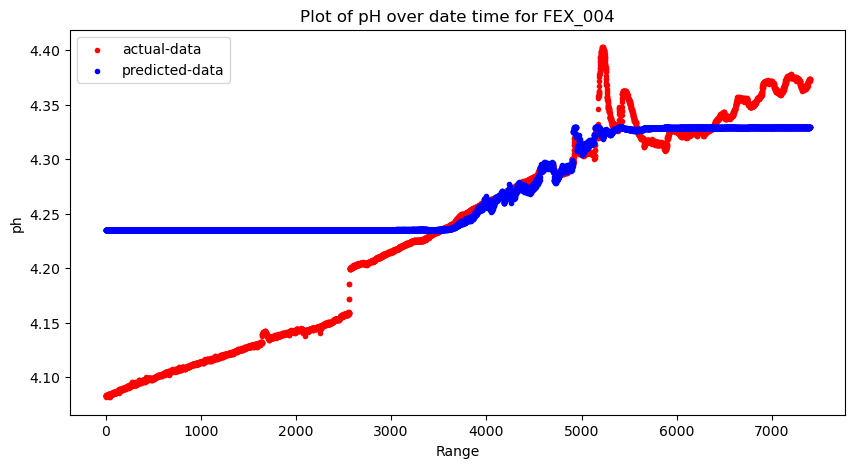

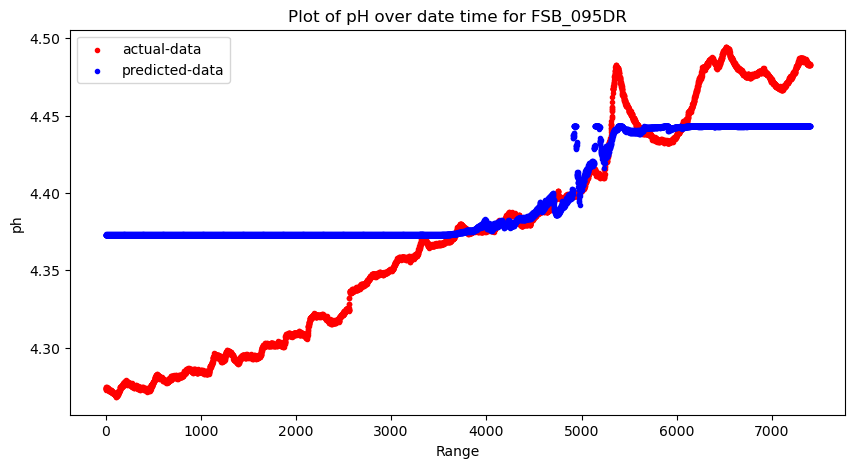

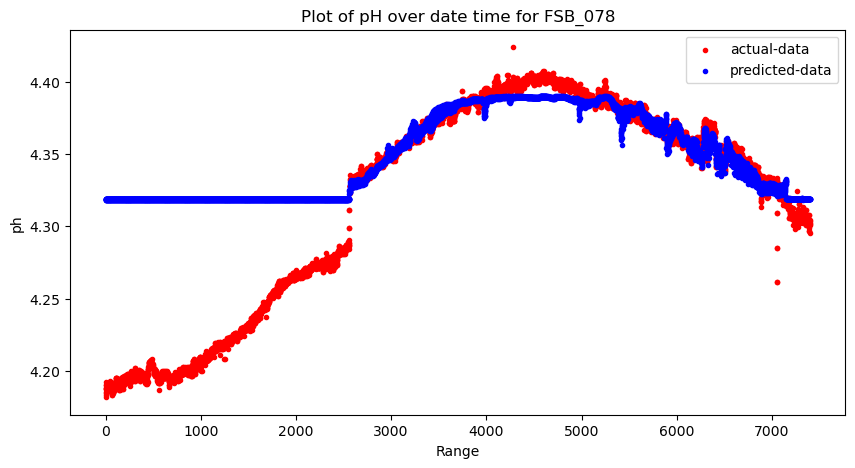

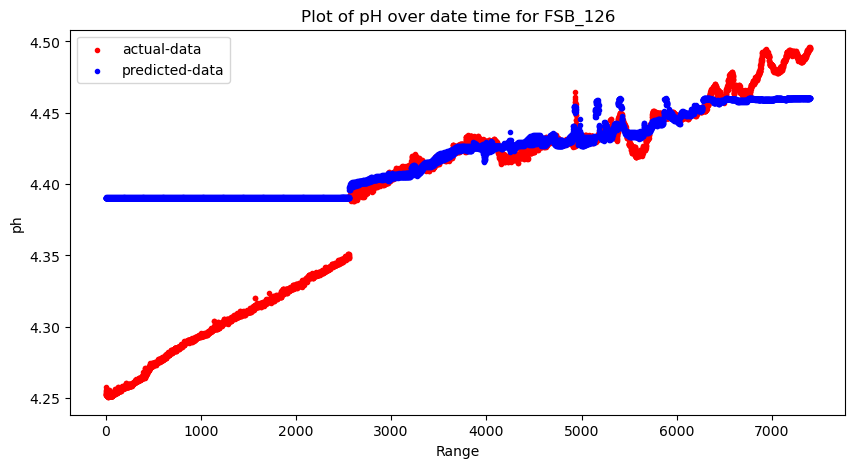

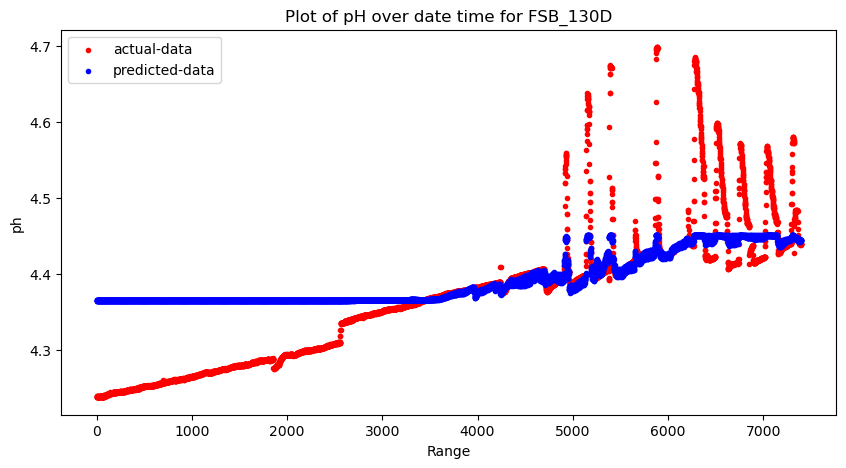

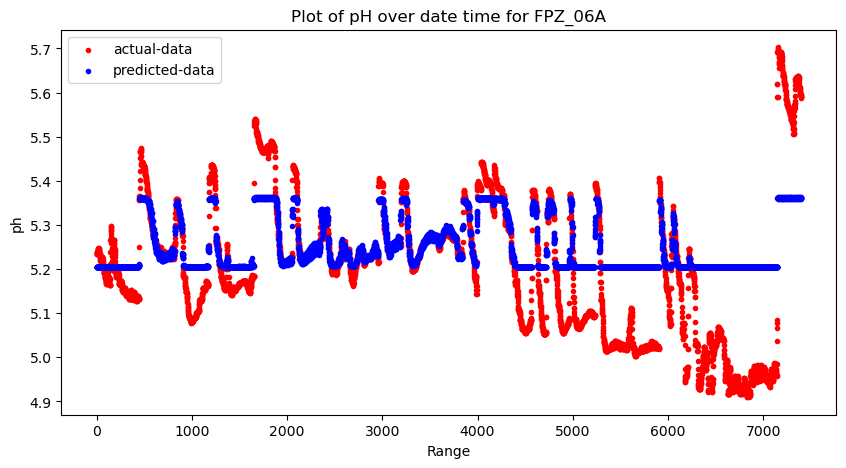

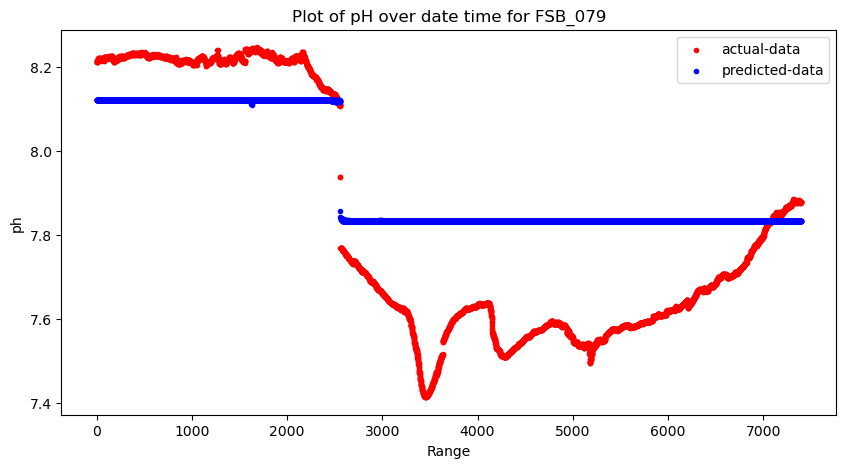

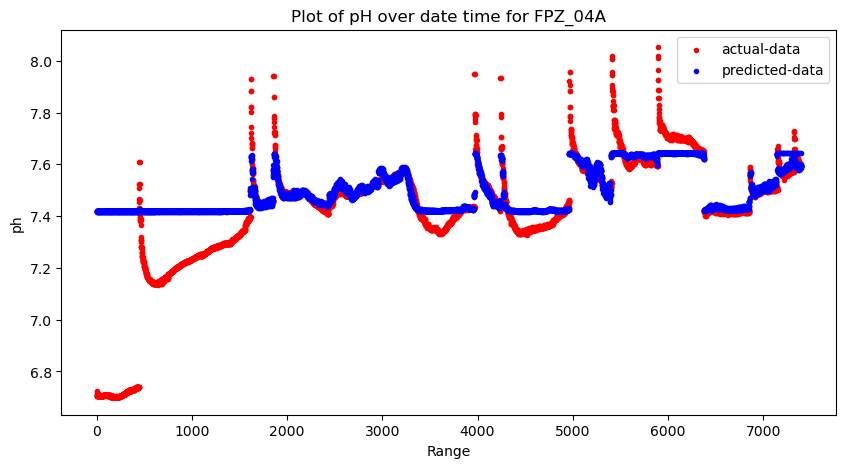

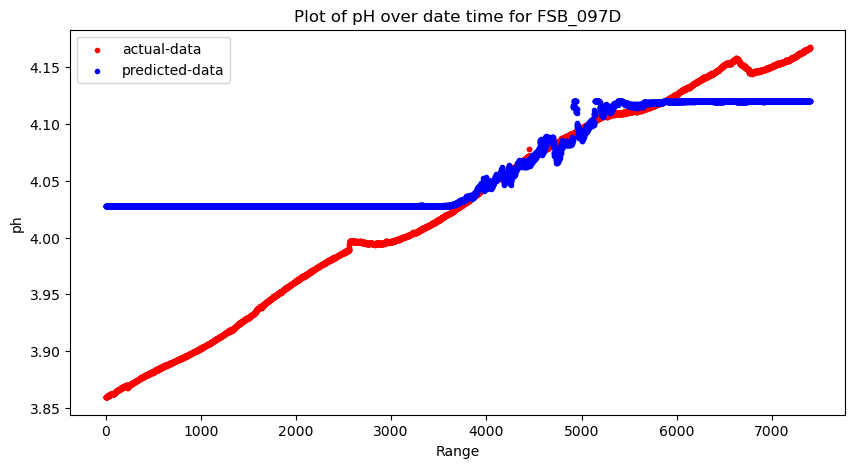

In [836]:
for index,station in enumerate(stations_name):
# index = 0

# print(len(reshaped_input_df[stations_name[index]]))
# print(len(reshaped_predicted_df[stations_name[index]]))
# print(reshaped_input_df[stations_name[index]].shape)
# print(reshaped_predicted_df[stations_name[index]].shape)

    plt.figure(figsize=(10, 5))
    plt.scatter(range(len(reshaped_input_df[stations_name[index]])), reshaped_input_df[stations_name[index]], marker='.', color="red", label="actual-data")
    plt.scatter(range(len(reshaped_predicted_df[stations_name[index]])), reshaped_predicted_df[stations_name[index]], marker='.', color="blue", label = "predicted-data")


    plt.xlabel('Range')
    plt.ylabel('ph')
    plt.title(f'Plot of pH over date time for {stations_name[index]}')
    plt.legend()
    plt.show()
        